In [ ]:
!pip install inference supervision
!pip install numpy
!pip install opencv-python
!pip install imutils
!pip install matplotlib

In [3]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
from imutils.perspective import four_point_transform
from inference_sdk import InferenceHTTPClient, InferenceConfiguration
import os

%matplotlib inline

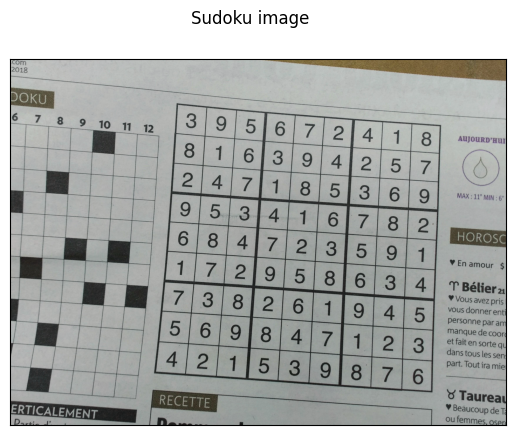

In [4]:
sudoku_image = cv2.imread("sudoku.jpeg")
gray = cv2.cvtColor(sudoku_image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots()
ax.imshow(sudoku_image)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle("Sudoku image")
plt.show()


# Blur

To blur the image we are going to perform a convolution between some averaging kernel and the image. We could use the box filter which will take the average of $n x n$ pixels and assign that value to the center pixel. 

For example, 

$A_3 = \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
\end{bmatrix}$

Box kernel $ = \frac{A}{||A||} = \begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} 
\end{bmatrix}$


It turns out that the Gaussian Kernel is a much better blur filter as it gives more weight to the nearby neighbors. 

The 2-D gaussian is represented by 
$G(u, v) = \frac{1}{2 \pi \sigma^2}e^{-\frac{u^2+v^2}{2\sigma^2}}$. 

Since we don't want to make the image ligher, we need to normalize the gaussian kernel. The kernel is a discrete representation of the continuous function, therefore we can normalize in the same way as above ($\frac{A}{||A||}$).  

Below, I have plotted the 2-D gaussian function. 

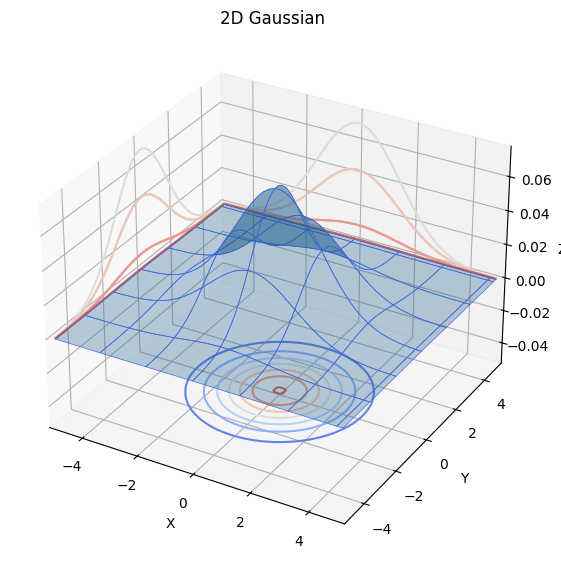

In [5]:
sigma = 1.5
x = np.linspace(-5, 5)
y = np.linspace(-5, 5)

x, y = np.meshgrid(x, y)
g = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))

figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(2, 1, 1, projection='3d')

ax.plot_surface(x, y, g, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
ax.set(xlim=(-5, 5), ylim=(-5, 5), zlim=(-0.05, 0.075),
       xlabel='X', ylabel='Y', zlabel='Z')
ax.contour(x, y, g, zdir='y', offset=5, cmap='coolwarm')
ax.contour(x, y, g, zdir='x', offset=-5, cmap='coolwarm')
ax.contour(x, y, g, zdir='z', offset=-0.05, cmap='coolwarm')

plt.title("2D Gaussian")
plt.show()

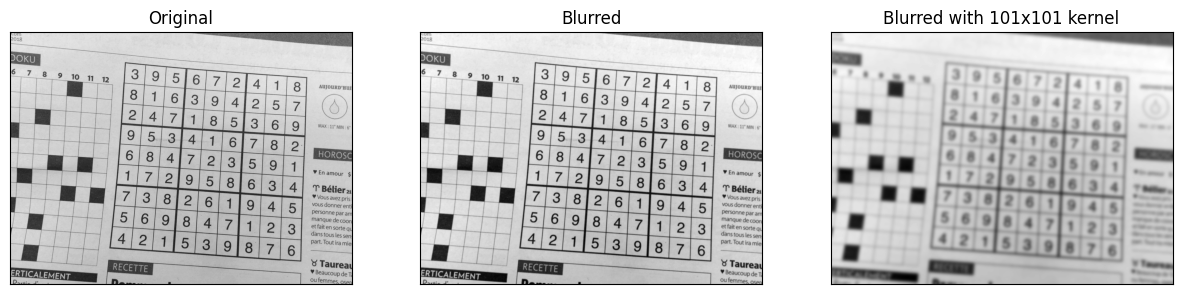

In [6]:
blur = cv2.GaussianBlur(gray, (15, 15), 0)

blur_100 = cv2.GaussianBlur(gray, (101, 101), 0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(x, y)

ax1.imshow(gray, cmap='gray')
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(blur, cmap='gray')
ax2.set_title("Blurred")
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(blur_100, cmap='gray')
ax3.set_title("Blurred with 101x101 kernel")
ax3.set_xticks([])
ax3.set_yticks([])

plt.show()

# Thresholding

Thresholding is going to replace any pixel below a given threshold value with a black pixel and replace any pixel above the threshold with a white value. 

Adaptive thresholding works similiarly to global thresholding but changes the threshold value in a local region. This will work better when there is variable lighting in the image.

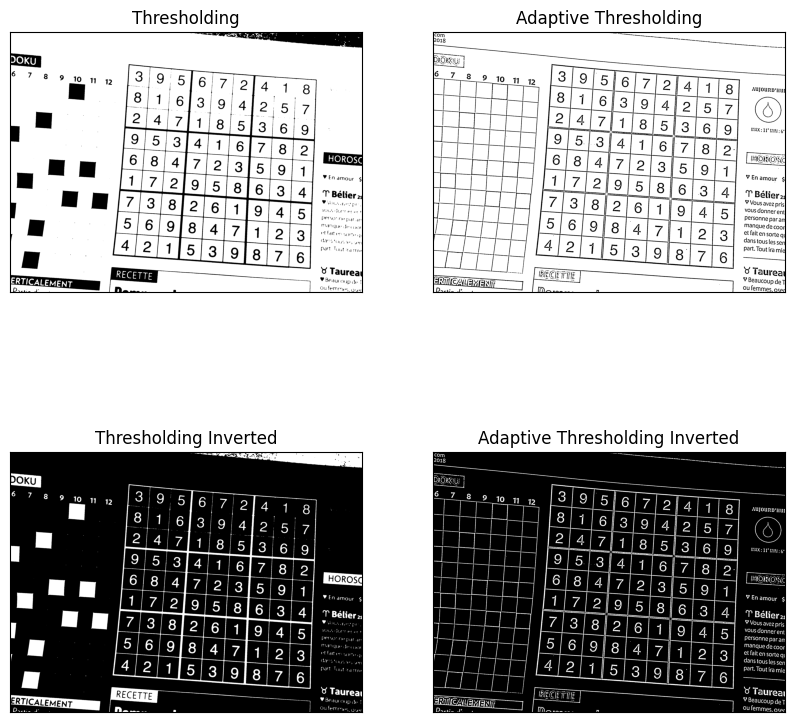

In [7]:
_, threshold = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)
threshold_inverted = cv2.bitwise_not(threshold)

adaptive_threshold = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 10)
adaptive_threshold_inverted = cv2.bitwise_not(adaptive_threshold)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].imshow(threshold, cmap='gray')
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])
axs[0][0].set_title("Thresholding")

axs[0][1].imshow(adaptive_threshold, cmap='gray')
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])
axs[0][1].set_title("Adaptive Thresholding")

axs[1][0].imshow(threshold_inverted, cmap='gray')
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])
axs[1][0].set_title("Thresholding Inverted")

axs[1][1].imshow(adaptive_threshold_inverted, cmap='gray')
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])
axs[1][1].set_title("Adaptive Thresholding Inverted")

plt.show()

From the above images, we can see the top right corner of the image after thresholding is faded. This is because this light might not be the same throughout the image so we cannot pick a value for the threshold that will perform equally as well throughout. 

From the adaptive thresholding image, we can see it does a pretty good job of finding the image boundary.

# Find sudoku grid

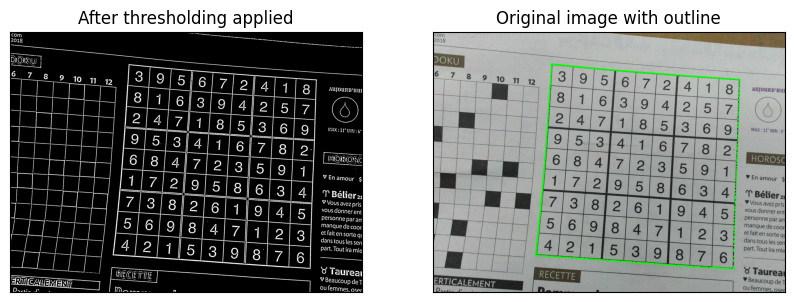

In [8]:
outlined_image = sudoku_image.copy()
threshold_copy = adaptive_threshold_inverted.copy()

countours = cv2.findContours(threshold_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
countours = imutils.grab_contours(countours)

largest_countour = max(countours, key=cv2.contourArea)

cv2.drawContours(outlined_image, largest_countour, -1, (0, 255, 0), 15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(threshold_copy, cmap='gray')
ax1.set_title("After thresholding applied")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(outlined_image)
ax2.set_title("Original image with outline")
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

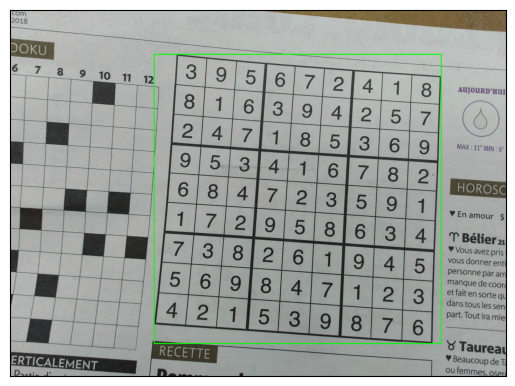

In [9]:
x, y, w, h = cv2.boundingRect(largest_countour)

show_bounary_img = sudoku_image.copy()

fig, ax = plt.subplots()

ax.set_xticks([])
ax.set_yticks([])
ax.imshow(cv2.rectangle(show_bounary_img, (x, y), (x + w, y + h), (0, 255, 0), 5))
plt.show()

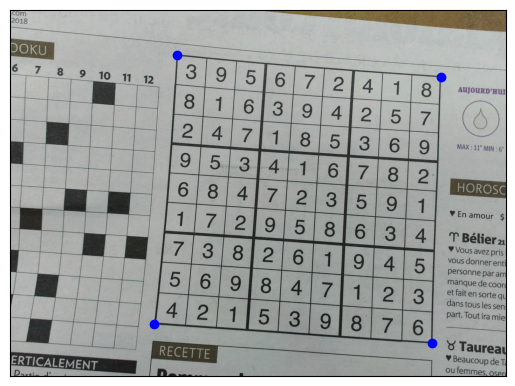

In [10]:
perimeter = cv2.arcLength(curve=largest_countour, closed=True)

shape = cv2.approxPolyDP(curve=largest_countour, epsilon=0.01 * perimeter, closed=True).reshape(4, 2)
_, ax = plt.subplots()
ax.imshow(sudoku_image)

for corner in shape:
    ax.scatter(corner[0], corner[1], color='blue')

ax.set_xticks([])
ax.set_yticks([])
plt.show()

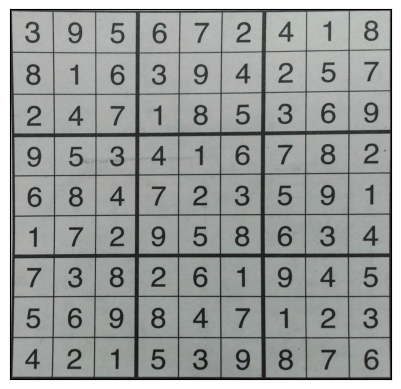

In [11]:
original = sudoku_image.copy()

cropped = four_point_transform(original, shape)

fig, ax = plt.subplots()
ax.imshow(cropped)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Split image into individual cells

[]

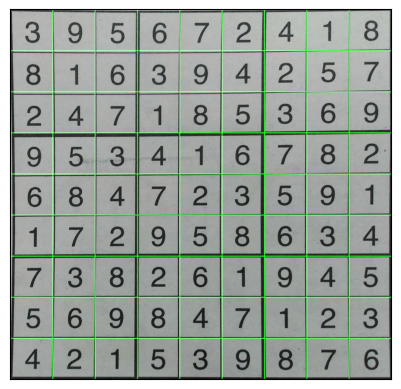

In [12]:
extract_image = cropped.copy()

dx = extract_image.shape[0] // 9
dy = extract_image.shape[1] // 9

for i in range(1, 9):
    extract_image[i * dx:i * dx + 5, :, 1] = 255
    extract_image[:, i * dy:i * dy + 5, 1] = 255

fig, ax = plt.subplots()

ax.imshow(extract_image)

ax.set_xticks([])
ax.set_yticks([])

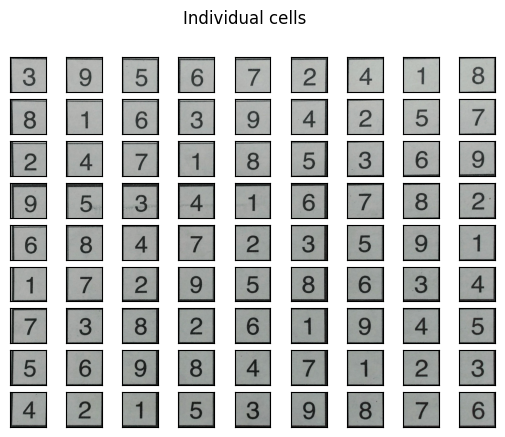

In [13]:
fig, axs = plt.subplots(9, 9)
fig.suptitle("Individual cells")

for x in range(9):
    for y in range(9):
        axs[x, y].imshow(cropped[dx * x:dx * (x + 1), dy * y: dy * (y + 1)])
        axs[x, y].set_xticks([])
        axs[x, y].set_yticks([])

plt.show()

# Extract digits

The following function will print the image of a sudoku board represented as a list of lists.

In [14]:
def print_board(board):
    for i in range(9):
        if (i == 0):
            print(
                "================================"
            )
        for j, val in enumerate(board[i]):
            print_pipe = [1, 2, 4, 5, 7, 8]
            if (j == 0):
                print("||", end="")
            if (j in print_pipe):
                print("|", end="")
            if (j % 3 == 0 and j != 0):
                print("||", end="")
            if (val == -1):
                print("  ", end="")
            else:
                print(str(val) + " ", end="")
        if ((i + 1) % 3 == 0):
            print(
                "||\n================================"
            )
        else:
            print("||")
    print("\n")

We are going to use Roboflow's digit recognition model (`digit-recognition-qcxre/1`) to extract the digits from the image. We are going to use a low confidence threshold.

We can display the bounding box for each found digit.

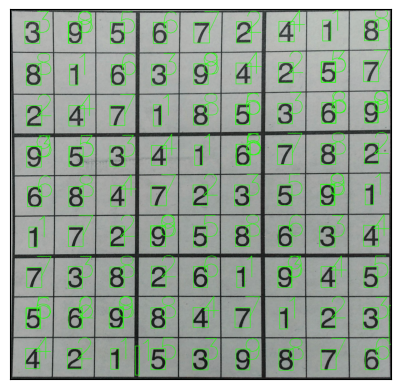

In [15]:
custom_configuration = InferenceConfiguration(confidence_threshold=0.0001)

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key=os.environ["ROBOFLOW_API_KEY"]
)

labeled_photo = cropped.copy()

with CLIENT.use_configuration(custom_configuration):
    results = CLIENT.infer(labeled_photo, model_id="digit-recognition-qcxre/1")
    predictions = results['predictions']

for bounding_box in predictions:
    x1 = bounding_box['x'] - bounding_box['width'] / 2
    x2 = bounding_box['x'] + bounding_box['width'] / 2
    y1 = bounding_box['y'] - bounding_box['height'] / 2
    y2 = bounding_box['y'] + bounding_box['height'] / 2

    cv2.rectangle(labeled_photo, (int(x1), int(y1)), (int(x2), int(y2)), (36, 255, 12), 2, )
    cv2.putText(labeled_photo, bounding_box['class'], (int(bounding_box['x']), int(bounding_box['y'])),
                cv2.FONT_HERSHEY_SIMPLEX, 5, (36, 255, 12), 2)

fig, ax = plt.subplots()
ax.imshow(labeled_photo)

ax.set_xticks([])
ax.set_yticks([])

plt.show()


Finally, we are going to create iterate through the sudoku cells and find the prediction that is contained in the cell. From the image above, we notice that you can have multiple predictions for a single cell. We are going to take the prediction with the highest confidence as our predicted digit.

In [16]:
sudoku_board = []

for x in range(9):
    row = []
    for y in range(9):
        best_confidence = 0
        best_match = ' '
        for prediction in predictions:
            if dx * x < prediction['y'] < dx * (x + 1) and dy * y < prediction['x'] < dy * (y + 1):
                if prediction['confidence'] > best_confidence:
                    best_match = prediction['class']
                    best_confidence = prediction['confidence']

        row.append(best_match)
        axs[x, y].imshow(cropped[dx * x:dx * (x + 1), dy * y: dy * (y + 1)])
        axs[x, y].set_xticks([])
        axs[x, y].set_yticks([])

    sudoku_board.append(row)

We can see the original image compared to our extracted sudoku board.

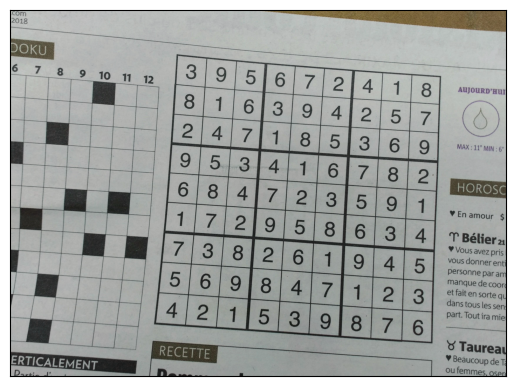

||3 |9 |5 ||6 |7 |2 ||4 |1 |8 ||
||8 |1 |6 ||3 |9 |4 ||2 |5 |7 ||
||2 |4 |7 ||1 |8 |5 ||3 |6 |9 ||
||9 |5 |3 ||4 |1 |6 ||7 |8 |2 ||
||6 |8 |4 ||7 |2 |3 ||5 |9 |1 ||
||1 |7 |2 ||9 |5 |8 ||6 |3 |4 ||
||7 |3 |8 ||2 |6 |1 ||9 |4 |5 ||
||5 |6 |9 ||8 |4 |7 ||1 |2 |3 ||
||4 |2 |1 ||5 |3 |9 ||8 |7 |6 ||




In [17]:
fig, ax = plt.subplots()
ax.imshow(sudoku_image)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

print_board(sudoku_board)